In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm

# define the data, 2-D sphere

(-1.5, 1.5)

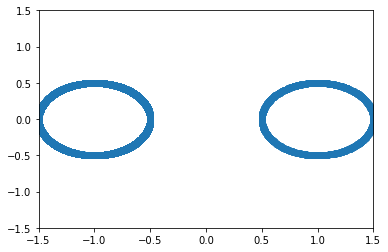

In [2]:
mean_points = torch.tensor([[-1,0],[1,0]])
sample_size = [9000, 1000]
data_dim = 2
train_data = torch.randn(sum(sample_size),data_dim)
train_data /= torch.norm(train_data,dim=1).reshape(-1,1)
train_data *= 0.5

now_sample_sum = 0
for ii in range(len(sample_size)):
    train_data[now_sample_sum:(now_sample_sum+sample_size[ii])] += mean_points[ii].reshape(1,-1)
    now_sample_sum += sample_size[ii]
    
plt.scatter(train_data[:,0],train_data[:,1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

# define the time-dependent MLP-UNet

In [3]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, cond_emb_dim = 32, time_emb_dim=32, scale = 9, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))
        
        self.input_dim = input_dim

        self.cond_embed = MyBlock(cond_dim,cond_emb_dim,block_layer)
        self.cond_embed_dim = cond_emb_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_emb_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_emb_dim , second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_emb_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_emb_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_emb_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, ti, xc_inp = None):
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        if xc_inp is None:
            xc = torch.zeros(x.shape[0],self.cond_embed_dim).to(x.device) - 1
        else:
            xc = self.cond_embed(xc_inp)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)
        
        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# define the denoising loss

In [4]:
def denoising_loss(net, batch_data, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.reshape(-1,1)) + torch.sqrt(noisy_levels.reshape(-1,1)) * noise
    predicted_noise = net(noisy_data, noisy_levels)
    loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

def index_iterator(data_len, batch_size, shuffle=True):
    if shuffle:
        indices = np.random.permutation(data_len)
    else:
        indices = np.arange(data_len)
    for i in range(0, data_len, batch_size):
        yield indices[i:i+batch_size]

# Generation function

In [5]:
def ddim_sampling(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1.):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    for _ in range(total_steps-1):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

# training with EMA

  0%|          | 0/2000 [00:00<?, ?it/s]

  2%|▏         | 49/2000 [01:33<1:00:55,  1.87s/it, avg_loss=0.493, last_loss=0.397]

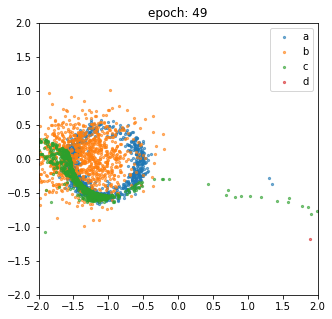

  2%|▎         | 50/2000 [01:38<1:47:46,  3.32s/it, avg_loss=0.493, last_loss=0.397]

saved at epoch 49


  5%|▍         | 99/2000 [03:11<59:05,  1.86s/it, avg_loss=0.485, last_loss=0.289]  

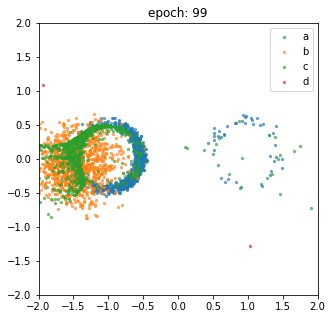

  5%|▌         | 100/2000 [03:16<1:44:45,  3.31s/it, avg_loss=0.485, last_loss=0.289]

saved at epoch 99


  7%|▋         | 149/2000 [04:49<57:32,  1.87s/it, avg_loss=0.48, last_loss=0.339]   

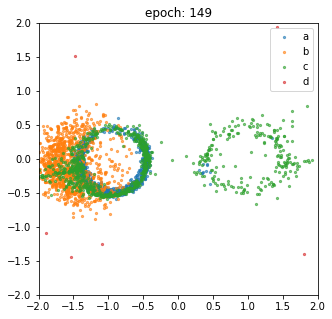

  8%|▊         | 150/2000 [04:54<1:41:45,  3.30s/it, avg_loss=0.48, last_loss=0.339]

saved at epoch 149


 10%|▉         | 199/2000 [06:27<55:36,  1.85s/it, avg_loss=0.479, last_loss=0.522]  

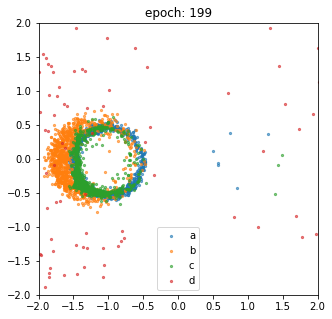

 10%|█         | 200/2000 [06:32<1:39:31,  3.32s/it, avg_loss=0.479, last_loss=0.522]

saved at epoch 199


 12%|█▏        | 249/2000 [08:05<54:30,  1.87s/it, avg_loss=0.47, last_loss=0.508]   

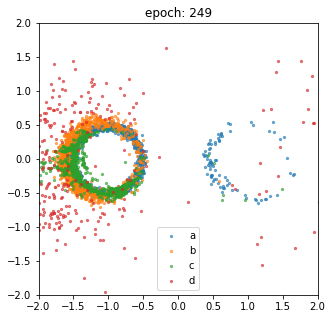

 12%|█▎        | 250/2000 [08:10<1:37:16,  3.34s/it, avg_loss=0.47, last_loss=0.508]

saved at epoch 249


 15%|█▍        | 299/2000 [09:43<52:51,  1.86s/it, avg_loss=0.465, last_loss=0.608]  

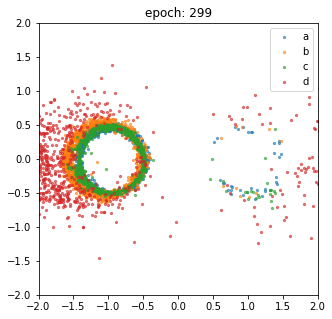

 15%|█▌        | 300/2000 [09:48<1:33:40,  3.31s/it, avg_loss=0.465, last_loss=0.608]

saved at epoch 299


 17%|█▋        | 349/2000 [11:22<51:36,  1.88s/it, avg_loss=0.485, last_loss=0.797]  

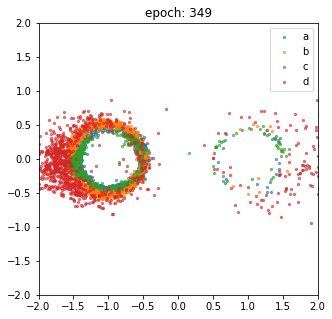

 18%|█▊        | 350/2000 [11:26<1:31:12,  3.32s/it, avg_loss=0.485, last_loss=0.797]

saved at epoch 349


 20%|█▉        | 399/2000 [12:59<49:45,  1.86s/it, avg_loss=0.473, last_loss=0.438]  

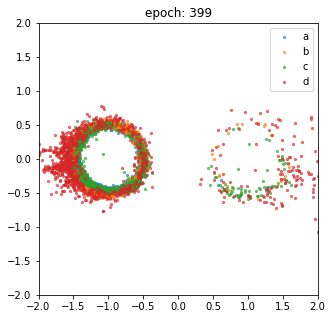

 20%|██        | 400/2000 [13:04<1:28:16,  3.31s/it, avg_loss=0.473, last_loss=0.438]

saved at epoch 399


 22%|██▏       | 449/2000 [14:38<48:11,  1.86s/it, avg_loss=0.475, last_loss=0.273]  

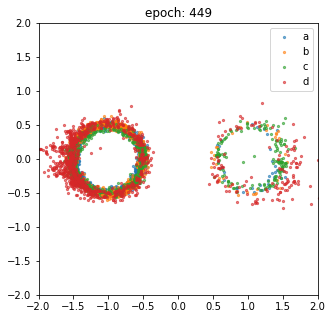

 22%|██▎       | 450/2000 [14:42<1:25:07,  3.30s/it, avg_loss=0.475, last_loss=0.273]

saved at epoch 449


 25%|██▍       | 499/2000 [16:16<46:47,  1.87s/it, avg_loss=0.466, last_loss=0.635]  

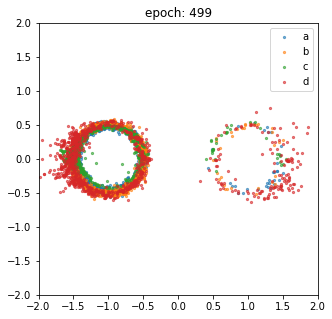

 25%|██▌       | 500/2000 [16:20<1:22:48,  3.31s/it, avg_loss=0.466, last_loss=0.635]

saved at epoch 499


 27%|██▋       | 549/2000 [17:54<45:01,  1.86s/it, avg_loss=0.477, last_loss=0.376]  

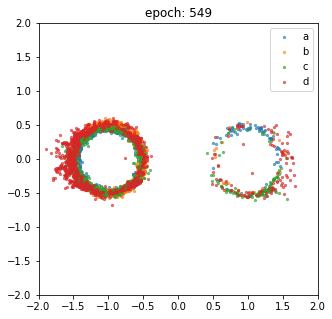

 28%|██▊       | 550/2000 [17:58<1:19:46,  3.30s/it, avg_loss=0.477, last_loss=0.376]

saved at epoch 549


 30%|██▉       | 599/2000 [19:32<43:32,  1.86s/it, avg_loss=0.475, last_loss=0.53]   

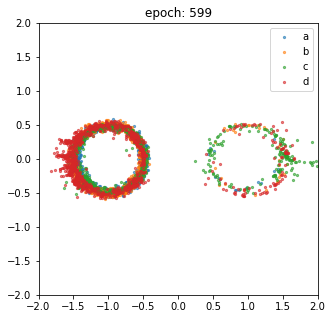

 30%|███       | 600/2000 [19:36<1:17:19,  3.31s/it, avg_loss=0.475, last_loss=0.53]

saved at epoch 599


 32%|███▏      | 649/2000 [21:10<42:06,  1.87s/it, avg_loss=0.478, last_loss=0.549]  

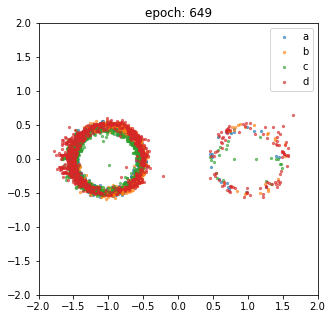

 32%|███▎      | 650/2000 [21:15<1:14:23,  3.31s/it, avg_loss=0.478, last_loss=0.549]

saved at epoch 649


 35%|███▍      | 699/2000 [22:48<40:28,  1.87s/it, avg_loss=0.481, last_loss=0.29]   

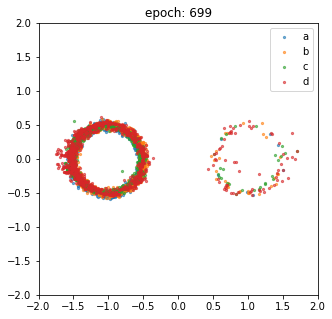

 35%|███▌      | 700/2000 [22:53<1:11:31,  3.30s/it, avg_loss=0.481, last_loss=0.29]

saved at epoch 699


 37%|███▋      | 749/2000 [24:26<39:01,  1.87s/it, avg_loss=0.476, last_loss=0.184]  

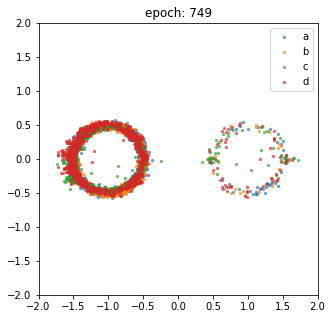

 38%|███▊      | 750/2000 [24:31<1:08:54,  3.31s/it, avg_loss=0.476, last_loss=0.184]

saved at epoch 749


 40%|███▉      | 799/2000 [26:04<37:25,  1.87s/it, avg_loss=0.477, last_loss=0.281]  

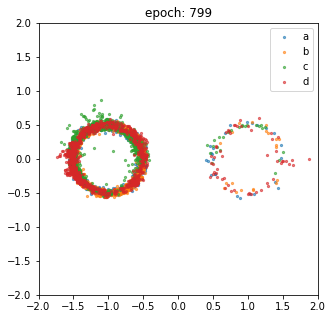

 40%|████      | 800/2000 [26:09<1:06:45,  3.34s/it, avg_loss=0.477, last_loss=0.281]

saved at epoch 799


 42%|████▏     | 849/2000 [27:43<35:53,  1.87s/it, avg_loss=0.47, last_loss=0.625]   

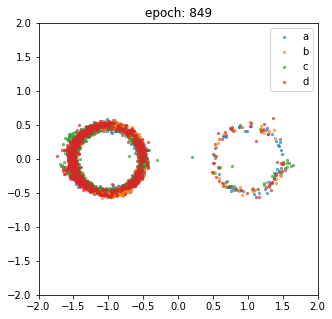

 42%|████▎     | 850/2000 [27:47<1:03:24,  3.31s/it, avg_loss=0.47, last_loss=0.625]

saved at epoch 849


 45%|████▍     | 899/2000 [29:21<34:10,  1.86s/it, avg_loss=0.471, last_loss=0.369]  

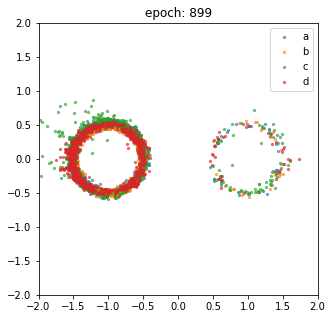

 45%|████▌     | 900/2000 [29:26<1:00:32,  3.30s/it, avg_loss=0.471, last_loss=0.369]

saved at epoch 899


 47%|████▋     | 949/2000 [30:59<32:39,  1.86s/it, avg_loss=0.457, last_loss=0.382]  

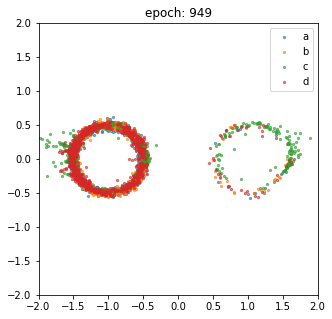

 48%|████▊     | 950/2000 [31:04<57:46,  3.30s/it, avg_loss=0.457, last_loss=0.382]

saved at epoch 949


 50%|████▉     | 999/2000 [32:37<31:08,  1.87s/it, avg_loss=0.47, last_loss=0.396] 

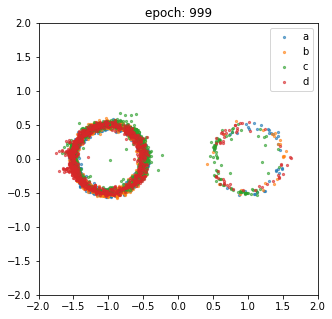

 50%|█████     | 1000/2000 [32:42<55:10,  3.31s/it, avg_loss=0.47, last_loss=0.396]

saved at epoch 999


 52%|█████▏    | 1049/2000 [34:15<29:37,  1.87s/it, avg_loss=0.465, last_loss=0.514]

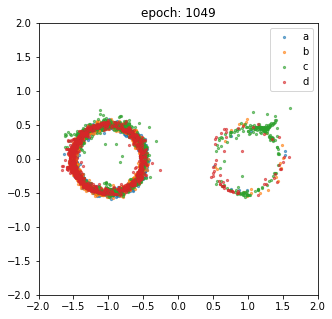

 52%|█████▎    | 1050/2000 [34:20<52:26,  3.31s/it, avg_loss=0.465, last_loss=0.514]

saved at epoch 1049


 55%|█████▍    | 1099/2000 [35:53<28:04,  1.87s/it, avg_loss=0.479, last_loss=0.801]

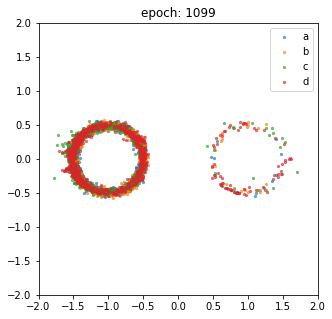

 55%|█████▌    | 1100/2000 [35:58<49:36,  3.31s/it, avg_loss=0.479, last_loss=0.801]

saved at epoch 1099


 57%|█████▋    | 1149/2000 [37:32<26:27,  1.87s/it, avg_loss=0.488, last_loss=0.78] 

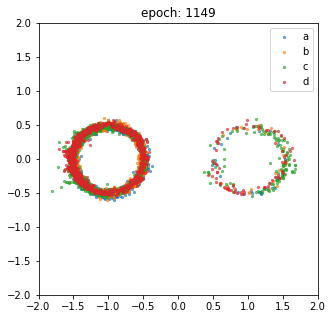

 57%|█████▊    | 1150/2000 [37:37<46:50,  3.31s/it, avg_loss=0.488, last_loss=0.78]

saved at epoch 1149


 60%|█████▉    | 1199/2000 [39:10<24:48,  1.86s/it, avg_loss=0.481, last_loss=0.337] 

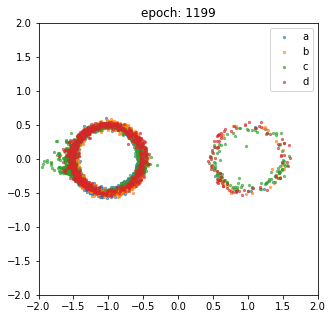

 60%|██████    | 1200/2000 [39:15<44:04,  3.31s/it, avg_loss=0.481, last_loss=0.337]

saved at epoch 1199


 62%|██████▏   | 1249/2000 [40:48<23:22,  1.87s/it, avg_loss=0.481, last_loss=0.532]

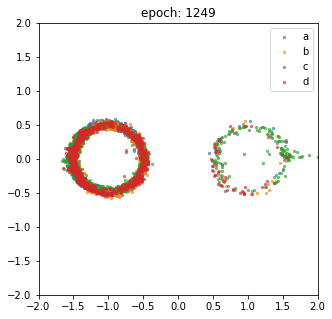

 62%|██████▎   | 1250/2000 [40:53<41:24,  3.31s/it, avg_loss=0.481, last_loss=0.532]

saved at epoch 1249


 65%|██████▍   | 1299/2000 [42:26<21:41,  1.86s/it, avg_loss=0.477, last_loss=0.387]

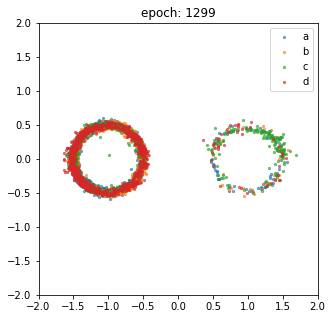

 65%|██████▌   | 1300/2000 [42:31<38:28,  3.30s/it, avg_loss=0.477, last_loss=0.387]

saved at epoch 1299


 67%|██████▋   | 1349/2000 [44:04<20:16,  1.87s/it, avg_loss=0.481, last_loss=1.63] 

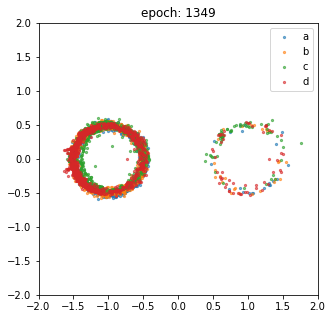

 68%|██████▊   | 1350/2000 [44:09<35:51,  3.31s/it, avg_loss=0.481, last_loss=1.63]

saved at epoch 1349


 70%|██████▉   | 1399/2000 [45:43<18:45,  1.87s/it, avg_loss=0.481, last_loss=0.354]

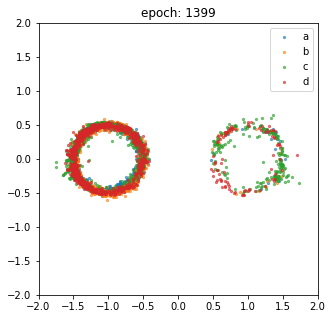

 70%|███████   | 1400/2000 [45:47<33:05,  3.31s/it, avg_loss=0.481, last_loss=0.354]

saved at epoch 1399


 72%|███████▏  | 1449/2000 [47:21<17:01,  1.85s/it, avg_loss=0.474, last_loss=0.495]

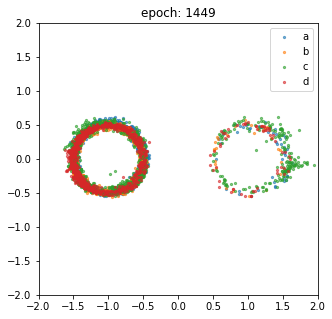

 72%|███████▎  | 1450/2000 [47:25<30:13,  3.30s/it, avg_loss=0.474, last_loss=0.495]

saved at epoch 1449


 75%|███████▍  | 1499/2000 [48:59<15:32,  1.86s/it, avg_loss=0.48, last_loss=0.962] 

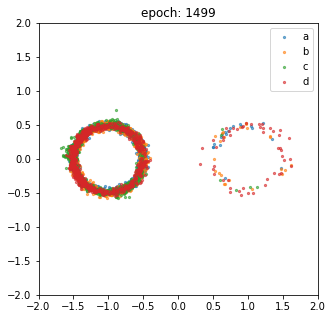

 75%|███████▌  | 1500/2000 [49:03<27:30,  3.30s/it, avg_loss=0.48, last_loss=0.962]

saved at epoch 1499


 77%|███████▋  | 1549/2000 [50:37<14:02,  1.87s/it, avg_loss=0.484, last_loss=0.28] 

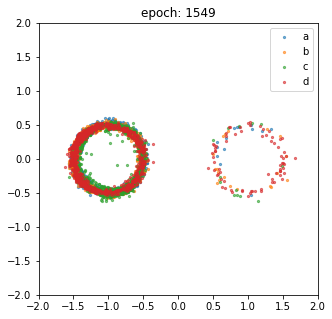

 78%|███████▊  | 1550/2000 [50:41<24:47,  3.31s/it, avg_loss=0.484, last_loss=0.28]

saved at epoch 1549


 80%|███████▉  | 1599/2000 [52:15<12:27,  1.86s/it, avg_loss=0.47, last_loss=0.488] 

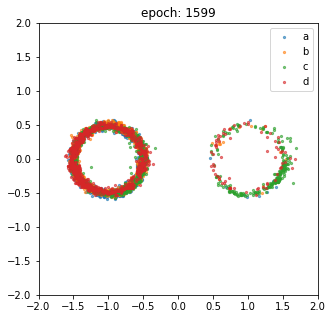

 80%|████████  | 1600/2000 [52:20<22:01,  3.30s/it, avg_loss=0.47, last_loss=0.488]

saved at epoch 1599


 82%|████████▏ | 1649/2000 [53:53<10:57,  1.87s/it, avg_loss=0.47, last_loss=0.277] 

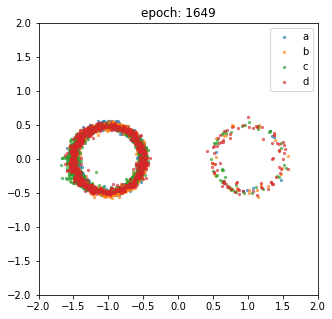

 82%|████████▎ | 1650/2000 [53:58<19:21,  3.32s/it, avg_loss=0.47, last_loss=0.277]

saved at epoch 1649


 85%|████████▍ | 1699/2000 [55:31<09:20,  1.86s/it, avg_loss=0.476, last_loss=0.357]

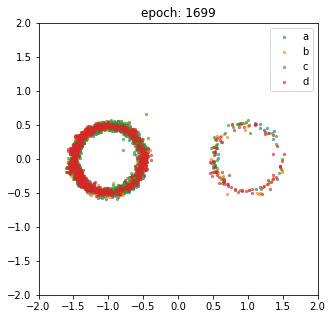

 85%|████████▌ | 1700/2000 [55:36<16:28,  3.29s/it, avg_loss=0.476, last_loss=0.357]

saved at epoch 1699


 87%|████████▋ | 1749/2000 [57:09<07:49,  1.87s/it, avg_loss=0.481, last_loss=0.307]

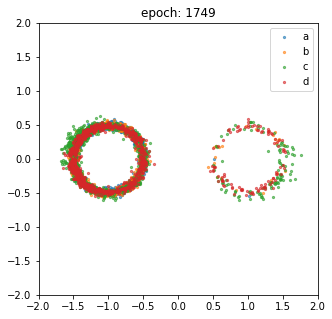

 88%|████████▊ | 1750/2000 [57:14<13:48,  3.31s/it, avg_loss=0.481, last_loss=0.307]

saved at epoch 1749


 90%|████████▉ | 1799/2000 [58:47<06:13,  1.86s/it, avg_loss=0.461, last_loss=0.287]

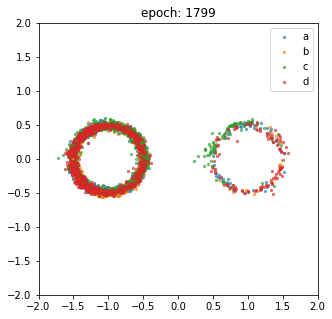

 90%|█████████ | 1800/2000 [58:52<11:07,  3.34s/it, avg_loss=0.461, last_loss=0.287]

saved at epoch 1799


 92%|█████████▏| 1849/2000 [1:00:26<04:41,  1.87s/it, avg_loss=0.481, last_loss=0.344]

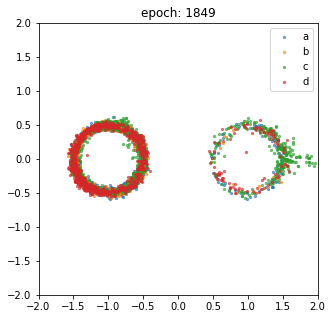

 92%|█████████▎| 1850/2000 [1:00:31<08:15,  3.31s/it, avg_loss=0.481, last_loss=0.344]

saved at epoch 1849


 95%|█████████▍| 1899/2000 [1:02:04<03:08,  1.86s/it, avg_loss=0.479, last_loss=0.556]

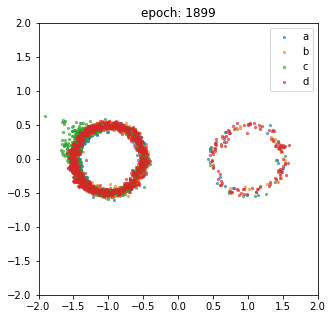

 95%|█████████▌| 1900/2000 [1:02:09<05:30,  3.30s/it, avg_loss=0.479, last_loss=0.556]

saved at epoch 1899


 97%|█████████▋| 1949/2000 [1:03:43<01:37,  1.91s/it, avg_loss=0.486, last_loss=0.415]

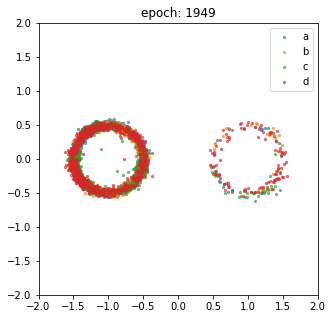

 98%|█████████▊| 1950/2000 [1:03:47<02:48,  3.37s/it, avg_loss=0.486, last_loss=0.415]

saved at epoch 1949


100%|█████████▉| 1999/2000 [1:05:21<00:01,  1.87s/it, avg_loss=0.472, last_loss=1.26] 

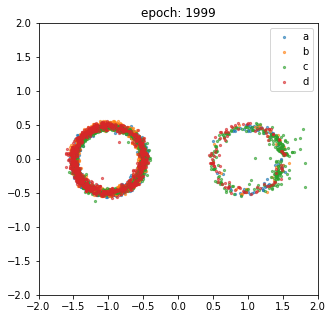

100%|██████████| 2000/2000 [1:05:26<00:00,  1.96s/it, avg_loss=0.472, last_loss=1.26]

saved at epoch 1999


In [30]:
EPOCH = 2000

lr=1e-4
batch_size = 32

model = UNet_MLP(data_dim, 1, 1).cuda()
EMA_model = UNet_MLP(data_dim, 1, 1).cuda()
EMA_model.load_state_dict(deepcopy(model.state_dict()))
train_data = train_data.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(train_data), batch_size):
        optimizer.zero_grad()
        loss  = denoising_loss(model, train_data[batch_idx])
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)
    
    for p, ema_p in zip(model.parameters(), EMA_model.parameters()):
        ema_p.data.mul_(0.99).add_(0.01, p.data)

    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

    if (epoch + 1) % 50 == 0:
        ema_sample_points = ddim_sampling(EMA_model, 1000, eta = 1)
        sample_points = ddim_sampling(model, 1000, eta = 1)
        ema_sample_points_eta0 = ddim_sampling(EMA_model, 1000, eta = 0)
        sample_points_eta0 = ddim_sampling(model, 1000, eta = 0)
        plt.figure(figsize=(5,5))
        plt.scatter(sample_points[:,0], sample_points[:,1], s=5, alpha=0.6, label="a")
        plt.scatter(ema_sample_points[:,0], ema_sample_points[:,1], s=5,alpha=0.6, label="b")
        plt.scatter(sample_points_eta0[:,0], sample_points_eta0[:,1], s=5,alpha=0.6, label="c")
        plt.scatter(ema_sample_points_eta0[:,0], ema_sample_points_eta0[:,1], s=5,alpha=0.6, label="d")
        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.legend()
        plt.title("epoch: {}".format(epoch))
        plt.savefig("temp_results/ddim_{}_mg.png".format(epoch))
        plt.show()
        torch.save(model.state_dict(), "temp_results/ddim_mg.pth".format(epoch))
        torch.save(EMA_model.state_dict(), "temp_results/ddim_ema_mg.pth".format(epoch))
        print("saved at epoch {}".format(epoch))

# inference

In [16]:
model = UNet_MLP(data_dim, 1, 1).cuda()
model.load_state_dict(torch.load("temp_results/ddim_ema_mg.pth"))

# ema_sample_points1 = ddim_sampling(EMA_model, 1000, eta = 0.2)
ema_sample_points2 = ddim_sampling(model, 1000, total_steps=1000, eta = 0.1)
# ema_sample_points3 = ddim_sampling(EMA_model, 1000, eta = 0.4)
# ema_sample_points4 = ddim_sampling(EMA_model, 1000, eta = 0.5)

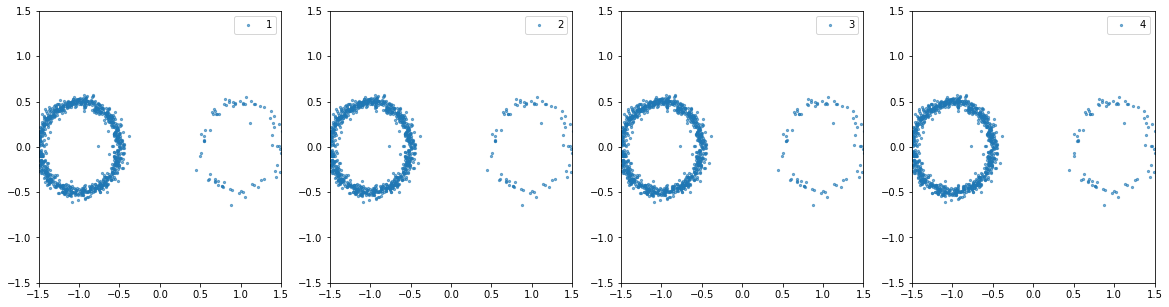

In [17]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5, alpha=0.6, label="1")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.subplot(1,4,2)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5,alpha=0.6, label="2")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.subplot(1,4,3)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5,alpha=0.6, label="3")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.subplot(1,4,4)
plt.scatter(ema_sample_points2[:,0], ema_sample_points2[:,1], s=5,alpha=0.6, label="4")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.legend()
plt.show()

# reward function

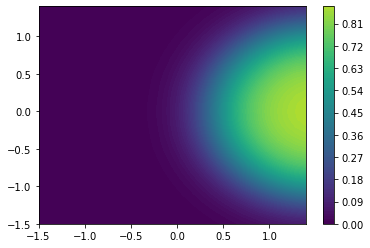

In [6]:
reward_fn = lambda x: 1 / (1 + np.exp(2* (x[:,0] - 1.5) ** 2  +2*(x[:,1] - 0) ** 2 - 2))
# visualize reward fn
x1, x2 = np.meshgrid(np.arange(-1.5,1.5, 0.1), np.arange(-1.5,1.5, 0.1))
z_values = reward_fn(np.concatenate([x1.reshape(-1,1),x2.reshape(-1,1)],axis=1)).reshape(x1.shape)
plt.contourf(x1,x2,z_values,100)
plt.clim(0,1)
plt.colorbar()

# finetuning with reward function

# visualize data with reward

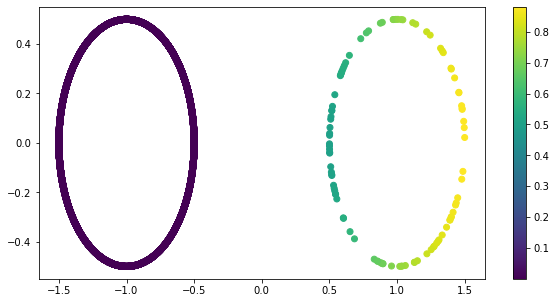

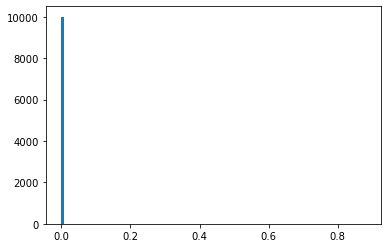

In [7]:
mean_points = torch.tensor([[-1,0],[1,0]])
sample_size = [10000, 100]
data_dim = 2
data_for_finetune = torch.randn(sum(sample_size),data_dim)
data_for_finetune /= torch.norm(data_for_finetune,dim=1).reshape(-1,1)
data_for_finetune *= 0.5

now_sample_sum = 0
for ii in range(len(sample_size)):
    data_for_finetune[now_sample_sum:(now_sample_sum+sample_size[ii])] += mean_points[ii].reshape(1,-1)
    now_sample_sum += sample_size[ii]


#data_for_finetune = ddim_sampling(finetuned_diffusion, 1000, total_steps=1000, eta = 0.1)
reward_data = reward_fn(data_for_finetune)

plt.figure(figsize=(10,5))
plt.scatter(data_for_finetune[:,0],data_for_finetune[:,1],c=reward_data)
plt.colorbar() 
plt.show()

plt.hist(reward_data, bins=100)
plt.show()

data_for_finetune = torch.FloatTensor(data_for_finetune).cuda()
reward_data = torch.FloatTensor(reward_data.reshape(-1,1)).cuda()

In [8]:
def denoising_loss_with_reward(net, batch_data, batch_reward_data, eps = 1e-5):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.view(-1,1)) + torch.sqrt(noisy_levels.view(-1,1)) * noise
    predicted_noise = net(noisy_data, noisy_levels, batch_reward_data)
    loss  = torch.mean(torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

def reward_weighted_denoising_loss(net, batch_data, batch_reward_data, eps = 1e-5, eta = 1):
    batch_len = len(batch_data)
    noisy_levels = (torch.rand(batch_len).cuda()) * (1 - 2 * eps) + eps # 0.001 ~ 1
    noise = torch.randn(batch_data.shape).cuda()
    noisy_data = batch_data * torch.sqrt(1 - noisy_levels.view(-1,1)) + torch.sqrt(noisy_levels.view(-1,1)) * noise
    predicted_noise = net(noisy_data, noisy_levels)
    loss  = torch.mean((torch.exp(batch_reward_data.flatten()/eta)) * torch.sum((predicted_noise - noise)**2, dim = 1)) 
    return loss

def ddim_sampling_with_reward(model, sample_size = 100, total_steps = 1000, eps = 1e-5, eta = 1., reward = 0):
    # generation
    now_coeff = 1 - eps
    interp = now_coeff / total_steps
    sample_points = torch.randn(sample_size,2).cuda()

    if type(reward) == int or type(reward) == float:
        reward = torch.zeros(sample_size,1).cuda() + reward
    
    for _ in range(total_steps-1):
        nl = eta * np.sqrt(now_coeff - interp) 
        with torch.no_grad():
            direction = model(sample_points, torch.zeros(sample_size).cuda() + now_coeff, reward)
        sample_points = np.sqrt(1-now_coeff+interp) * (sample_points - np.sqrt(now_coeff) * direction) / np.sqrt(1-now_coeff) + np.sqrt(max([now_coeff - interp - nl**2, 0])) * direction + nl * torch.randn(sample_size,2).cuda()
        now_coeff -= interp

    return sample_points.cpu().numpy()

# finetune with pre reward distribution

In [9]:
finetuned_diffusion = UNet_MLP(2, 1, 1).cuda()
finetuned_diffusion.load_state_dict(torch.load("temp_results/ddim_ema_mg.pth"))

<All keys matched successfully>

In [139]:
EPOCH = 1000

lr=1e-4
batch_size = 128
optimizer = torch.optim.Adam(finetuned_diffusion.parameters(), lr=lr)

progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(data_for_finetune), batch_size):
        optimizer.zero_grad()
        loss  = denoising_loss_with_reward(finetuned_diffusion, data_for_finetune[batch_idx], reward_data[batch_idx])
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

    

    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})


100%|██████████| 1000/1000 [00:52<00:00, 19.02it/s, avg_loss=0.37, last_loss=0.318]


# finetune with reward-weighted loss

In [41]:
finetuned_diffusion = UNet_MLP(2, 1, 1).cuda()
finetuned_diffusion.load_state_dict(torch.load("temp_results/ddim_ema_mg.pth"))

<All keys matched successfully>

 10%|▉         | 99/1000 [00:48<07:12,  2.08it/s, avg_loss=13.9, last_loss=1.64]

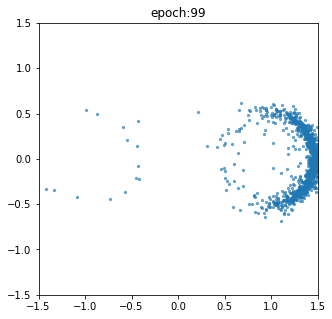

 17%|█▋        | 168/1000 [01:22<06:50,  2.02it/s, avg_loss=7.02, last_loss=1.68]


KeyboardInterrupt: 

In [10]:
EPOCH = 1000

lr=1e-4
batch_size = 128
optimizer = torch.optim.Adam(finetuned_diffusion.parameters(), lr=lr)

progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(data_for_finetune), batch_size):
        optimizer.zero_grad()
        loss  = reward_weighted_denoising_loss(finetuned_diffusion, data_for_finetune[batch_idx], reward_data[batch_idx],eta=0.1)
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)

    if (epoch+1) % 100 == 0:
        sample_points1 = ddim_sampling(finetuned_diffusion, 1000, eta = 0.1)
        plt.figure(figsize=(5,5))
        plt.scatter(sample_points1[:,0], sample_points1[:,1], s=5, alpha=0.6)
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.title("epoch:{}".format(epoch))
        plt.show()

    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})

In [36]:
base_reward_dist = np.quantile(reward_data.cpu().numpy().flatten(),q=np.linspace(0,1,1000))

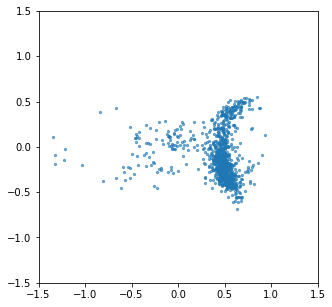

In [143]:
sample_size = 1000
adjust_reward = base_reward_dist + 0.5
adjust_reward[adjust_reward > base_reward_dist[-1]] = base_reward_dist[-1]
use_reward = torch.FloatTensor(np.random.choice(adjust_reward, sample_size, replace=False)).reshape(-1,1)
sample_points1 = ddim_sampling_with_reward(finetuned_diffusion, 1000, eta = 0.1, reward = 0.5)
plt.figure(figsize=(5,5))
plt.scatter(sample_points1[:,0], sample_points1[:,1], s=5, alpha=0.6)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

# iterated finetuning

In [45]:
sample_size = 1000
adjust_reward = base_reward_dist + 0.05
adjust_reward[adjust_reward > base_reward_dist[-1]] = base_reward_dist[-1]
use_reward = torch.FloatTensor(np.random.choice(adjust_reward, sample_size, replace=False)).reshape(-1,1)
data_for_finetune = ddim_sampling_with_reward(finetuned_diffusion, 1000, eta = 0.1, reward = use_reward.cuda())
reward_data = reward_fn(data_for_finetune)

plt.figure(figsize=(10,5))
plt.scatter(data_for_finetune[:,0],data_for_finetune[:,1],c=reward_data)
plt.colorbar() 
plt.show()

plt.hist(reward_data, bins=100)
plt.show()

data_for_finetune = torch.FloatTensor(data_for_finetune).cuda()
reward_data = torch.FloatTensor(reward_data.reshape(-1,1)).cuda()



0.880321204662323

In [ ]:
EPOCH = 100

lr=1e-4
batch_size = 128
optimizer = torch.optim.Adam(finetuned_diffusion.parameters(), lr=lr)

progress = tqdm(range(EPOCH))
for epoch in progress:
    avg_loss = 0
    totals = 0
    for batch_idx in index_iterator(len(data_for_finetune), batch_size):
        optimizer.zero_grad()
        loss  = denoising_loss_with_reward(finetuned_diffusion, data_for_finetune[batch_idx], reward_data[batch_idx])
        loss.backward()
        optimizer.step()
        totals += len(batch_idx)
        avg_loss += loss.item() * len(batch_idx)


    progress.set_postfix({"avg_loss":avg_loss/totals,"last_loss":loss.item()})